In [94]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
%matplotlib inline
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc

from sklearn.ensemble import AdaBoostClassifier

In [42]:
credit = pd.read_csv('D:/Datasets/credit-default.csv')
credit.shape

(1000, 21)

## Parameter Tuning

In [24]:
credit_dummies = pd.get_dummies(credit)
train,test = train_test_split(credit_dummies, test_size = 0.3, random_state = 100)

train_x = train.drop('default',axis = 1)
test_x = test.drop('default',axis = 1)

train_y = train['default']
test_y = test['default']

In [25]:
test_x.shape[0]

300

In [40]:
test_pred = np.ones(test_x.shape[0])
print(accuracy_score(test_y,test_pred))
#confusion_matrix(test_y,test_pred,labels = [1,2])

0.73


In [41]:
# 
df_pred = pd.DataFrame({'actual':test_y,'predicted':test_pred})
#TN
print(((df_pred['actual']==1) & (df_pred['predicted']==1)).sum())
#TP
print(((df_pred['actual']==2) & (df_pred['predicted']==2)).sum())
#FP
print(((df_pred['actual']==1) & (df_pred['predicted']==2)).sum())
#FN
print(((df_pred['actual']==2) & (df_pred['predicted']==1)).sum())

219
0
0
81


In [46]:
model = RandomForestClassifier(random_state = 100)
model.fit(train_x,train_y)
test_pred = model.predict(test_x)
print(accuracy_score(test_y,test_pred))
#confusion_matrix(test_y,test_pred,labels = [1,2])
test_pred[:5]

0.76


array([1, 2, 1, 2, 1], dtype=int64)

In [45]:
# probability of positive and negative , use predict_proba instead of predict
probs = pd.DataFrame(model.predict_proba(test_x),columns = ['Neg_1','Pos_2'])
probs.head()
#Prediction will be based on probability values .

,Neg_1,Pos_2
0,0.5,0.5
1,0.1,0.9
2,0.7,0.3
3,0.3,0.7
4,0.6,0.4


In [55]:
# take positive probability class alone , as we are trying to imporve Sensitivity. here the cut off value is 0.5 for the model
# is to predict 1 or 2 . so we are tuning that value = 0.5 . 
probs['Pos_2'].head()


0    0.5
1    0.9
2    0.3
3    0.7
4    0.4
Name: Pos_2, dtype: float64

In [59]:
#Here we are reducing the cut off of 0.5 to 0.4 using a user definedfunction and try to find if there is any change in sens/spec

cut_off = 0.4
test_pred2 = probs['Pos_2'].apply(lambda v : 2 if v > cut_off else 1)
test_pred2.head()
tn,fp,fn,tp = confusion_matrix(test_y,test_pred2,labels=[1,2]).ravel()
sensitivity = (tp) / (tp + fn)
specificity = (tn) / (tn + fp)
print('CUt_off %.2f,Sensitivity %.1f,Specificity %.1f' % (cut_off,sensitivity*100,specificity*100))

CUt_off 0.40,Sensitivity 48.1,Specificity 81.7


## ROC Curve

In [ ]:
# To choose the Best among the models
# what is the cut off to choose within the model

In [78]:
# For Cut off values of 1 to 0 , we are finding sens and spec values. MANUALLY

cut_offs = []
tpr = []
fpr = []
for cut_off in np.linspace(0,1,11): #np.linspace bwtween 0 and 1 , no of values
    #print(cut_off)
    test_pred2 = probs['Pos_2'].apply(lambda v : 2 if v > cut_off else 1)
    tn,fp,fn,tp = confusion_matrix(test_y,test_pred2,labels=[1,2]).ravel()
    sensitivity = (tp) / (tp + fn)
    specificity = (tn) / (tn + fp)
    #print('CUt_off %.2f,Sensitivity %.1f,Specificity %.1f' % (cut_off,sensitivity*100,specificity*100))
    cut_offs.append(cut_off)
    tpr.append(sensitivity)
    fpr.append(1-specificity)
#print(cut_offs)
#print('-----')
#print(tpr)
#print('-----')
#print('specificity')
#print(fpr)

## For 1 Model 1 ROC Curve

#import matplotlib.pyplot as plt
#plt.plot(fpr,tpr)

# by looking at the numbers we cannot find the cut off value , hence using ROC curves
#

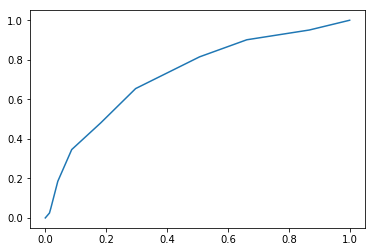

In [72]:
# ROC Curve using sklearn
from sklearn.metrics import roc_curve
fpr,tpr,cut_offs = roc_curve(test_y,probs['Pos_2'],pos_label =2)
plt.plot(fpr,tpr)

In [82]:
# DataFrame
df_roc = pd.DataFrame({'cut_off':cut_offs,'fpr':fpr,'tpr':tpr,'specificity': 1 - fpr })

df_roc['Youden_Index'] = df_roc['tpr'] + df_roc['specificity'] - 1

df_roc.sort_values(by='Youden_Index',ascending = False)

## Cut off value found is 0.4

TypeError: unsupported operand type(s) for -: 'int' and 'list'

In [83]:
# Optimal cut for this data is 0.4
test_pred_opt = probs['Pos_2'].apply(lambda v : 2 if v > 0.4 else 1)

In [ ]:
## Above is : WITHIN the MODEL how to have better sensitivity without reducing the specificity

In [ ]:
# BElow is for Comparing between models

### MODELS FOR CREDIT-DEFAULT

Random Forest AUC: 0.75
AdaBoost AUC: 0.74
DecisionTree AUC: 0.66


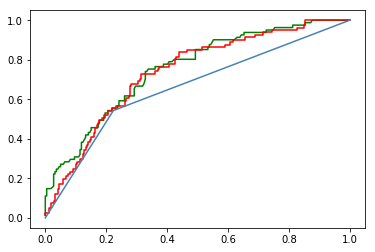

In [98]:


model1 = RandomForestClassifier(random_state = 100,n_estimators=1000)
model1.fit(train_x,train_y)
probs1 = pd.DataFrame(model1.predict_proba(test_x),columns=['Neg_1','Pos_2'])
fpr,tpr,cutoffs  = roc_curve(test_y,probs1['Pos_2'],pos_label=2 )
auc_rf = auc(fpr,tpr)
plt.plot(fpr,tpr,color ='green')

print('Random Forest AUC: %.2f' % auc_rf)


model2 = AdaBoostClassifier(random_state = 100)
model2.fit(train_x,train_y)
probs2 = pd.DataFrame(model2.predict_proba(test_x),columns=['Neg_1','Pos_2'])
fpr,tpr,cutoffs  = roc_curve(test_y,probs2['Pos_2'],pos_label=2 )
auc_ada = auc(fpr,tpr)
plt.plot(fpr,tpr,color ='red')

print('AdaBoost AUC: %.2f' % auc_ada)

model3 = DecisionTreeClassifier(random_state = 100)
model3.fit(train_x,train_y)
probs3 = pd.DataFrame(model3.predict_proba(test_x),columns=['Neg_1','Pos_2'])
fpr,tpr,cutoffs  = roc_curve(test_y,probs3['Pos_2'],pos_label=2 )
auc_dt = auc(fpr,tpr)
plt.plot(fpr,tpr,color ='steelblue')

print('DecisionTree AUC: %.2f' % auc_dt)

### ROC CURVE for Comparison between models in HR DataSet

In [99]:
hr = pd.read_csv('D:/Datasets/HRAnalytics.csv')

In [101]:
hr_dummies = pd.get_dummies(hr)
train, test = train_test_split(hr_dummies, test_size = 0.3, random_state = 100)

train_y_hr = train['Attrition']
test_y_hr = test['Attrition']

train_x_hr = train.drop('Attrition', axis = 1)
test_x_hr = test.drop('Attrition', axis = 1)

In [ ]:
tes

Random Forest AUC HR: 0.74
AdaBoost AUC HR: 0.78
DecisionTree AUC HR: 0.65


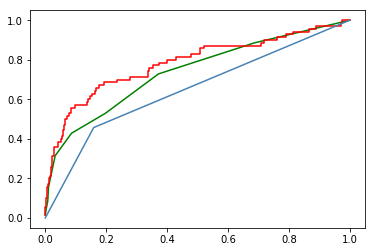

In [108]:
#Random Forest

model1_hr = RandomForestClassifier(random_state = 100)
model1_hr.fit(train_x_hr,train_y_hr)
probs1_hr = pd.DataFrame(model1_hr.predict_proba(test_x_hr),columns=['Neg_1','Pos_2'])
#probs1_hr.head()
fpr,tpr,cutoffs  = roc_curve(test_y_hr,probs1_hr['Pos_2'],pos_label=1 )
auc_rf_hr = auc(fpr,tpr)
plt.plot(fpr,tpr,color ='green')

print('Random Forest AUC HR: %.2f' % auc_rf_hr)

# AdaBoost

model2_hr = AdaBoostClassifier(random_state = 100)
model2_hr.fit(train_x_hr,train_y_hr)
probs2_hr = pd.DataFrame(model2_hr.predict_proba(test_x_hr),columns=['Neg_1','Pos_2'])
#probs1_hr.head()
fpr,tpr,cutoffs  = roc_curve(test_y_hr,probs2_hr['Pos_2'],pos_label=1 )
auc_ADA_hr = auc(fpr,tpr)
plt.plot(fpr,tpr,color ='red')

print('AdaBoost AUC HR: %.2f' % auc_ADA_hr)

# Decision Tree

model3_hr = DecisionTreeClassifier(random_state = 100)
model3_hr.fit(train_x_hr,train_y_hr)
probs3_hr = pd.DataFrame(model3_hr.predict_proba(test_x_hr),columns=['Neg_1','Pos_2'])
#probs1_hr.head()
fpr,tpr,cutoffs  = roc_curve(test_y_hr,probs3_hr['Pos_2'],pos_label=1 )
auc_DT_hr = auc(fpr,tpr)
plt.plot(fpr,tpr,color ='steelblue')

print('DecisionTree AUC HR: %.2f' % auc_DT_hr)


### ROC Models for Bank Data

In [110]:
bank = pd.read_csv('D:/Datasets/bank-full.csv',sep = ';')

In [111]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [113]:
bank_new = bank.drop('y', axis = 1)
bank_dummies = pd.get_dummies(bank_new)

bank_dummies['y'] = bank['y']
print(bank_dummies.shape)

train, test = train_test_split(bank_dummies, test_size = 0.3, random_state = 100)

train_y_bank = train['y']
test_y_bank = test['y']
train_x_bank = train.drop('y', axis = 1)
test_x_bank = test.drop('y', axis = 1)

(45211, 52)


Random Forest Bank AUC : 0.93
AdaBoost AUC BAnk: 0.91
DecisionTree Bank AUC: 0.71


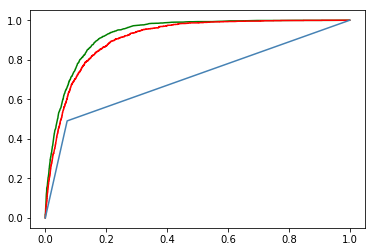

In [116]:
model1_bank = RandomForestClassifier(random_state = 100,n_estimators=1000)
model1_bank.fit(train_x_bank,train_y_bank)
probs1_bank = pd.DataFrame(model1_bank.predict_proba(test_x_bank),columns=['Neg_1','Pos_2'])
fpr,tpr,cutoffs  = roc_curve(test_y_bank,probs1_bank['Pos_2'],pos_label='yes' )
auc_rf_bank = auc(fpr,tpr)
plt.plot(fpr,tpr,color ='green')

print('Random Forest Bank AUC : %.2f' % auc_rf_bank)


model2_bank = AdaBoostClassifier(random_state = 100)
model2_bank.fit(train_x_bank,train_y_bank)
probs2_bank = pd.DataFrame(model2_bank.predict_proba(test_x_bank),columns=['Neg_1','Pos_2'])
fpr,tpr,cutoffs  = roc_curve(test_y_bank,probs2_bank['Pos_2'],pos_label='yes' )
auc_ada_bank = auc(fpr,tpr)
plt.plot(fpr,tpr,color ='red')

print('AdaBoost AUC BAnk: %.2f' % auc_ada_bank)

model3_bank = DecisionTreeClassifier(random_state = 100)
model3_bank.fit(train_x_bank,train_y_bank)
probs3_bank = pd.DataFrame(model3_bank.predict_proba(test_x_bank),columns=['Neg_1','Pos_2'])
fpr,tpr,cutoffs  = roc_curve(test_y_bank,probs3_bank['Pos_2'],pos_label='yes' )
auc_dt_bank = auc(fpr,tpr)
plt.plot(fpr,tpr,color ='steelblue')

print('DecisionTree Bank AUC: %.2f' % auc_dt_bank)